In [3]:
!pip install --upgrade ultralytics==8.0.186
!pip install torch torchvision torchaudio
!pip install opencv-python-headless
!pip install albumentations==1.4

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 618.4/618.4 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.6/123.6 kB 4.5 MB/s eta 0:00:00
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.4.20
    Uninstalling albumentations-1.4.20:
      Successfully uninstalled albumentations-1.4.20


In [4]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from ultralytics import YOLO
import numpy as np
from google.colab import drive
import os
import albumentations
import cv2
import torch.nn.functional as F
import matplotlib.pyplot as plt

drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
dataset_yolo = '/content/drive/My Drive/2024 Fall/COMS 6730/Projects/Person-Detection-YOLOV8N-Dectection'
epoch_number = 200
weights_path = '/content/drive/My Drive/2024 Fall/COMS 6730/Projects/YoloV8/yolov8n.pt'
data_yaml_path = '/content/drive/My Drive/2024 Fall/COMS 6730/Projects/Person-Detection-YOLOV8N-Dectection/data.yaml'
saved_path = f'trained_model'
results_folder_name = f"{dataset_yolo}_normal"

# model = YOLO(weights_path)
# model.train(
#     data=data_yaml_path,
#     epochs=epoch_number,
#     batch=32,
#     device='cuda',
#     project=saved_path,
#     name=results_folder_name,
#     patience=epoch_number,
#     pretrained=True,
#     lr0=0.001,
#     lrf=0.001,
#     dropout=0.2
# )

In [ ]:
# transform = transforms.Compose([
#     transforms.Resize((img_size, img_size)),
#     transforms.ToTensor(),
# ])

In [ ]:
class CustomLoss(nn.Module):
    def __init__(self, alpha=0.8, beta=0.5, gamma=0.7):
        super(CustomLoss, self).__init__()
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.epsilon = 1e-6

    def forward(self, outputs, targets):
        # 获取模型输出所在的设备
        device = outputs[0].boxes.conf.device

        # 提取 boxes 属性并移动到相同设备
        boxes = outputs[0].boxes

        # 将 conf 和 cls 张量移至正确设备
        person_conf = boxes.conf.to(device)  # 置信度分数
        person_cls = (boxes.cls == targets['person_class_index']).float().to(device)  # 类别是人物的概率

        # 将 targets 张量移至正确设备
        person_mask = targets['person_mask'].float().to(device)  # 人物区域的掩码
        background_mask = (1.0 - person_mask).to(device)         # 背景区域的掩码

        # 背景区域的误检损失
        L_bg = -torch.sum(
            (torch.log(person_cls + self.epsilon) + torch.log(person_conf + self.epsilon)) * background_mask
        ) / (torch.sum(background_mask) + self.epsilon).to(device)

        # 现有人物区域的抑制损失
        L_person = torch.sum(
            (torch.log(1.0 - person_cls + self.epsilon) + torch.log(1.0 - person_conf + self.epsilon)) * person_mask
        ) / (torch.sum(person_mask) + self.epsilon).to(device)

        # 边界框数量增加损失
        L_bbox = -torch.mean(torch.log(person_conf + self.epsilon)).to(device)

        # 总损失
        loss = self.alpha * L_bg + self.beta * L_person + self.gamma * L_bbox

        return loss

In [ ]:
def pgd_attack(model, images, targets, epsilon, alpha, num_iter):
    # 克隆输入图像，确保不修改原始图像，并设置需要计算梯度
    images_adv = images.clone().detach().requires_grad_(True)

    # 实例化定制的损失函数
    loss_fn = CustomLoss()

    # 使用 torch.enable_grad() 保证梯度跟踪
    with torch.enable_grad():
        # PGD攻击的主循环
        for i in range(num_iter):
            # 前向传播，获取模型输出
            outputs = model(images_adv)

            # 计算定制的损失
            loss = loss_fn(outputs, targets)

            # 反向传播，计算梯度
            loss.backward()

            # 获取输入图像的梯度符号
            grad_sign = images_adv.grad.sign()

            # 根据梯度更新对抗样本
            images_adv = images_adv + alpha * grad_sign

            # 确保扰动在允许的范围内（投影步骤）
            eta = torch.clamp(images_adv - images, min=-epsilon, max=epsilon)
            images_adv = torch.clamp(images + eta, min=0, max=1).detach()

            # 重新设置 requires_grad_ 为 True，以便下一次迭代计算梯度
            images_adv.requires_grad_(True)

    return images_adv

In [6]:
model_path = f"{results_folder_name}/weights/best.pt"
model = YOLO(model_path)
# model.eval()

/usr/local/lib/python3.10/dist-packages/ultralytics/nn/tasks.py:527: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(file, map_location='cpu'), file  # load


In [7]:
image_path = '/content/drive/My Drive/2024 Fall/COMS 6730/Projects/Person-Detection-YOLOV8N-Dectection/test/images/520_png.rf.ac32fafdf837220a1ebd88f58af11dd2.jpg'
image = cv2.imread(image_path)
# image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# image = cv2.resize(image, (640, 640))
# image = image / 255.0
# image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0)

In [8]:
person_class_index = 0

with torch.no_grad():
    outputs = model(image)

output = outputs[0]
# print(output)
boxes = output.boxes  # 这是一个 Boxes 对象
# print("Boxes data:", boxes.data)

# 提取检测的数量（即 num_anchors）
num_anchors = boxes.data.shape[0]  # 检测框的数量
print("Number of anchors (detections):", num_anchors)

person_mask = torch.zeros((1, num_anchors), dtype=torch.bool)  # [batch_size, num_anchors]

targets = {
    'person_class_index': person_class_index,
    'person_mask': person_mask
}


WARNING ⚠️ NMS time limit 0.550s exceeded
0: 640x640 1 Person, 79.9ms
Speed: 22.5ms preprocess, 79.9ms inference, 1836.6ms postprocess per image at shape (1, 3, 640, 640)


Number of anchors (detections): 1


In [9]:
epsilon = 0.05  # 最大扰动幅度
alpha = 0.01    # 每次迭代的步长
num_iter = 40   # 迭代次数

# 确保图像和模型在同一设备上（如GPU）
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# 由于我们需要在前向传播前获取模型的输出形状，以确定num_anchors，我们可以进行一次前向传播
# with torch.no_grad():
#     outputs = model(image)

# 假设模型输出的形状为
# outputs['cls_prob']: [batch_size, num_anchors, num_classes]
# 获取 num_anchors
# num_anchors = outputs['cls_prob'].shape[1]

# 更新 person_mask 的形状
# person_mask = torch.zeros((1, num_anchors), dtype=torch.bool).to(device)
# targets['person_mask'] = person_mask

# 调用 pgd_attack 函数
image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0).to(device)  # [1, 3, H, W]

In [10]:
with torch.no_grad():
    # 禁用参数的更新
    for param in model.parameters():
        param.requires_grad = False


In [20]:
def pgd_attack(model, images, epsilon, alpha, num_iter, target_class=0):
    """
    执行标准 PGD 攻击，最大化对抗扰动使模型对目标类别的置信度增加。
    参数:
        model: 加载的目标检测模型
        images: 输入图像 (tensor)，形状为 [B, C, H, W]
        epsilon: 扰动范围
        alpha: 每步的扰动步长
        num_iter: 迭代次数
        labels: 图像的真实标签，用于计算损失
        target_class: 目标类别索引 (int)，如果为 None，则对现有检测框增加误检
    返回:
        images_adv: 生成的对抗样本
    """
    # 克隆输入图像，确保不修改原始图像，并设置需要计算梯度
    images_adv = images.clone().detach().requires_grad_(True)

    # 启用梯度计算
    with torch.enable_grad():
        for i in range(num_iter):
            # 获取模型输出
            images_adv.retain_grad()
            outputs = model(images_adv)

            # 从输出中提取置信度分数 (例如 outputs[0].boxes.conf)
            confidences = outputs[0].boxes.conf  # 获取检测框的置信度分数
            # print(confidences)
            if target_class is not None:
                # 如果指定了 target_class，我们对该类别的概率进行攻击
                classes = outputs[0].boxes.cls
                target_conf = confidences[classes == target_class]
                if len(target_conf) == 0:  # 如果没有检测到目标类别，跳过本次迭代
                    continue
                Closs = -torch.mean(target_conf)  # 目标是增加对抗样本对目标类别的置信度
            else:
                # 如果未指定 target_class，则增加所有检测框的误检概率
                Closs = -torch.mean(confidences)  # 目标是增加所有框的置信度

            # loss = -images_adv.mean()
            loss = images_adv.mean() - Closs
            # 打印损失值（可选）
            print(loss)

            # 反向传播以计算梯度
            loss.requires_grad_(True)
            loss.backward(retain_graph=True)

            if images_adv.grad is None:
                print("images_adv.grad is None after backward")
                break

            # 获取梯度的符号
            grad_sign = images_adv.grad.sign()

            # 更新对抗样本
            images_adv = images_adv + alpha * grad_sign

            # 限制扰动范围并确保像素值在 [0, 1] 之间
            eta = torch.clamp(images_adv - images, min=-epsilon, max=epsilon)
            images_adv = torch.clamp(images + eta, min=0, max=3).detach()

            # 重新启用梯度以继续迭代
            images_adv.requires_grad_(True)

    return images_adv

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_path = f"{results_folder_name}/weights/best.pt"
model = YOLO(model_path)

# 参数设定
epsilon = 0.03  # 最大扰动
alpha = 0.05   # 每次迭代的步长
num_iter = 100   # 迭代次数

image_path = '/content/drive/My Drive/2024 Fall/COMS 6730/Projects/Person-Detection-YOLOV8N-Dectection/test/images/520_png.rf.ac32fafdf837220a1ebd88f58af11dd2.jpg'
image = cv2.imread(image_path)

outputs = model(image)

# 将图像和标签转换为 Tensor
images = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0).to(device) / 255.0
labels = torch.tensor([0]).to(device)

# 生成对抗样本
print("Generating adversarial examples...")
images_adv = pgd_attack(model, images, epsilon, alpha, num_iter)

# 使用对抗样本进行预测
outputs_adv = model(images_adv)

# 查看模型在对抗样本上的预测结果
# print(outputs_adv)

/usr/local/lib/python3.10/dist-packages/ultralytics/nn/tasks.py:527: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(file, map_location='cpu'), file  # load


Generating adversarial examples...
tensor(1.3744, device='cuda:0', grad_fn=<SubBackward0>)


0: 640x640 (no detections), 15.9ms
Speed: 0.0ms preprocess, 15.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

WARNING ⚠️ torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1.0299999713897705. Dividing input by 255.
0: 640x640 (no detections), 12.9ms
Speed: 0.0ms preprocess, 12.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

WARNING ⚠️ torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1.0299999713897705. Dividing input by 255.
0: 640x640 (no detections), 15.8ms
Speed: 0.0ms preprocess, 15.8ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

WARNING ⚠️ torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1.0299999713897705. Dividing input by 255.
0: 640x640 (no detections), 22.9ms
Speed: 0.0ms preprocess, 22.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING ⚠️ torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1.0299999713897705. Dividing in

In [22]:
def draw_boxes(image, outputs, class_names=None, color=(0, 255, 0)):
    """
    在图像上绘制检测框。

    参数：
        image: 原始图像（numpy 数组）
        outputs: YOLO 模型的输出
        class_names: 类别名称列表，例如 ['Person', 'Car', ...]
        color: 框的颜色（BGR 格式）
    返回：
        带有检测框的图像
    """
    # 复制图像，避免直接修改原图
    image_with_boxes = image.copy()

    # 获取检测框信息
    boxes = outputs[0].boxes  # 这是 YOLO 输出的检测框对象

    # 遍历所有检测框
    for box in boxes:
        # 提取框的坐标和置信度
        x1, y1, x2, y2 = map(int, box.xyxy[0].tolist())  # 转换为整数
        conf = float(box.conf[0])  # 置信度分数
        cls = int(box.cls[0])  # 类别索引

        # 绘制矩形框
        cv2.rectangle(image_with_boxes, (x1, y1), (x2, y2), color, 2)
        print(f"{conf:.2f}")
        # 显示类别和置信度
        label = f"{class_names[cls] if class_names else cls}: {conf:.2f}"
        cv2.putText(image_with_boxes, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    return image_with_boxes

0.85


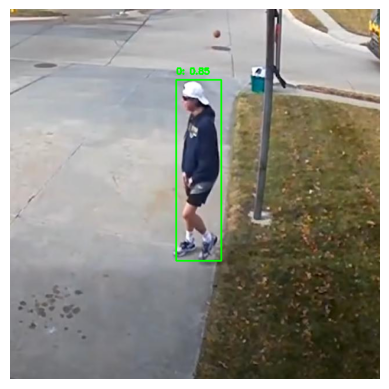

In [23]:
# 生成检测框图像
image_with_boxes = draw_boxes(image, outputs, [0])

# 显示图像
plt.imshow(cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

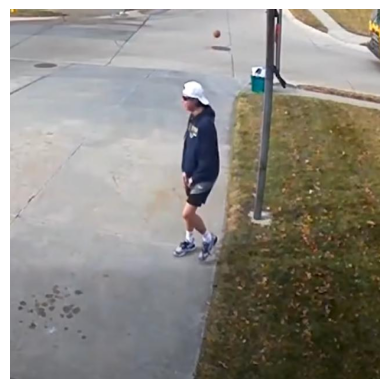

In [25]:
image_with_boxes = draw_boxes(image, outputs_adv, [0])

plt.imshow(cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

In [26]:
image_path = '/content/drive/My Drive/2024 Fall/COMS 6730/Projects/Person-Detection-YOLOV8N-Dectection/test/images/50_png.rf.8c631fbfe884e8a35e7a9592242389f1.jpg'
image = cv2.imread(image_path)

outputs = model(image)

# 将图像和标签转换为 Tensor
images = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0).to(device) / 255.0
labels = torch.tensor([0]).to(device)

# 生成对抗样本
print("Generating adversarial examples...")
images_adv = pgd_attack(model, images, epsilon, alpha, num_iter)

# 使用对抗样本进行预测
outputs_adv = model(images_adv)


0: 640x640 3 Persons, 20.7ms
Speed: 4.0ms preprocess, 20.7ms inference, 7.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 Persons, 9.7ms
Speed: 0.0ms preprocess, 9.7ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

WARNING ⚠️ torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1.0299999713897705. Dividing input by 255.
0: 640x640 (no detections), 10.0ms
Speed: 0.0ms preprocess, 10.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

WARNING ⚠️ torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1.0299999713897705. Dividing input by 255.
0: 640x640 (no detections), 9.3ms
Speed: 0.0ms preprocess, 9.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

WARNING ⚠️ torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1.0299999713897705. Dividing input by 255.
0: 640x640 (no detections), 9.6ms
Speed: 0.0ms preprocess, 9.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640

Generating adversarial examples...
tensor(1.1123, device='cuda:0', grad_fn=<SubBackward0>)


0: 640x640 (no detections), 12.0ms
Speed: 0.0ms preprocess, 12.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

WARNING ⚠️ torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1.0299999713897705. Dividing input by 255.
0: 640x640 (no detections), 10.1ms
Speed: 0.0ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

WARNING ⚠️ torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1.0299999713897705. Dividing input by 255.
0: 640x640 (no detections), 9.8ms
Speed: 0.0ms preprocess, 9.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

WARNING ⚠️ torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1.0299999713897705. Dividing input by 255.
0: 640x640 (no detections), 11.8ms
Speed: 0.0ms preprocess, 11.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

WARNING ⚠️ torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1.0299999713897705. Dividing inpu

0.76
0.58
0.30


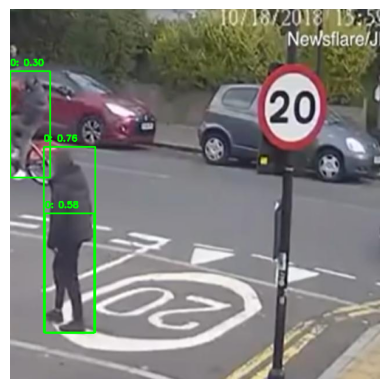

In [27]:
# 生成检测框图像
image_with_boxes = draw_boxes(image, outputs, [0])

# 显示图像
plt.imshow(cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

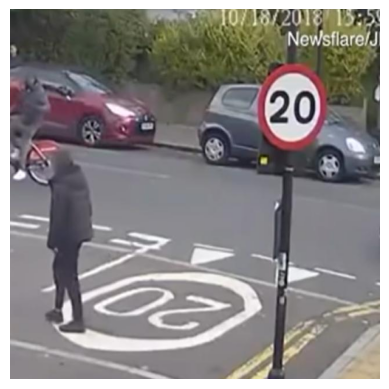

In [28]:
image_with_boxes = draw_boxes(image, outputs_adv, [0])

plt.imshow(cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

In [29]:
image_path = '/content/drive/My Drive/2024 Fall/COMS 6730/Projects/Person-Detection-YOLOV8N-Dectection/test/images/541_png.rf.ec9614119dfe10f5fb1cda98f657b47e.jpg'
image = cv2.imread(image_path)

outputs = model(image)

# 将图像和标签转换为 Tensor
images = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0).to(device) / 255.0
labels = torch.tensor([0]).to(device)

# 生成对抗样本
print("Generating adversarial examples...")
images_adv = pgd_attack(model, images, epsilon, alpha, num_iter)

# 使用对抗样本进行预测
outputs_adv = model(images_adv)


0: 640x640 4 Persons, 12.6ms
Speed: 2.8ms preprocess, 12.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 Persons, 8.5ms
Speed: 0.0ms preprocess, 8.5ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

WARNING ⚠️ torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1.0299999713897705. Dividing input by 255.
0: 640x640 (no detections), 9.6ms
Speed: 0.0ms preprocess, 9.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

WARNING ⚠️ torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1.0299999713897705. Dividing input by 255.
0: 640x640 (no detections), 10.1ms
Speed: 0.0ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

WARNING ⚠️ torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1.0299999713897705. Dividing input by 255.
0: 640x640 (no detections), 9.7ms
Speed: 0.0ms preprocess, 9.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640

Generating adversarial examples...
tensor(0.9789, device='cuda:0', grad_fn=<SubBackward0>)


Speed: 0.0ms preprocess, 9.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

WARNING ⚠️ torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1.0299999713897705. Dividing input by 255.
0: 640x640 (no detections), 10.5ms
Speed: 0.0ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

WARNING ⚠️ torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1.0299999713897705. Dividing input by 255.
0: 640x640 (no detections), 13.5ms
Speed: 0.0ms preprocess, 13.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

WARNING ⚠️ torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1.0299999713897705. Dividing input by 255.
0: 640x640 (no detections), 11.0ms
Speed: 0.0ms preprocess, 11.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

WARNING ⚠️ torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1.0299999713897705. Dividing input by 255.
0: 640x640 (no detection

0.67
0.59
0.41
0.26


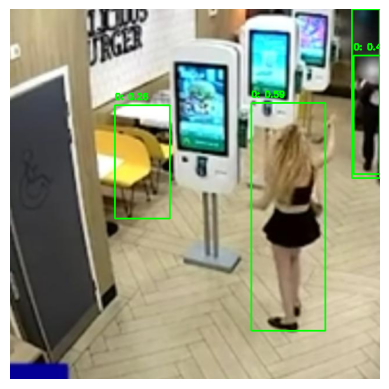

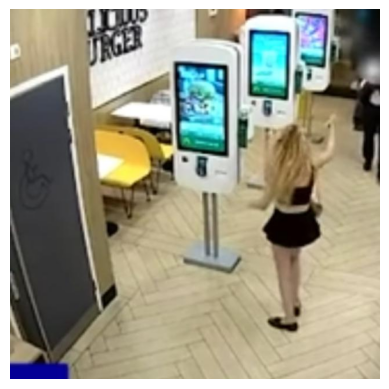

In [30]:
# 生成检测框图像
image_with_boxes = draw_boxes(image, outputs, [0])

# 显示图像
plt.imshow(cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

image_with_boxes = draw_boxes(image, outputs_adv, [0])

plt.imshow(cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

In [33]:
image_path = '/content/drive/My Drive/2024 Fall/COMS 6730/Projects/Person-Detection-YOLOV8N-Dectection/test/images/552_png.rf.db52aefafea5e76c45f6d0d6eeb6760b.jpg'
image = cv2.imread(image_path)

outputs = model(image)

# 将图像和标签转换为 Tensor
images = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0).to(device) / 255.0
labels = torch.tensor([0]).to(device)

# 生成对抗样本
print("Generating adversarial examples...")
images_adv = pgd_attack(model, images, epsilon, alpha, num_iter)

# 使用对抗样本进行预测
outputs_adv = model(images_adv)


0: 640x640 2 Persons, 9.7ms
Speed: 2.5ms preprocess, 9.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 Persons, 7.7ms
Speed: 0.0ms preprocess, 7.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

WARNING ⚠️ torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1.0299999713897705. Dividing input by 255.
0: 640x640 (no detections), 9.7ms
Speed: 0.0ms preprocess, 9.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

WARNING ⚠️ torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1.0299999713897705. Dividing input by 255.
0: 640x640 (no detections), 11.5ms
Speed: 0.0ms preprocess, 11.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

WARNING ⚠️ torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1.0299999713897705. Dividing input by 255.
0: 640x640 (no detections), 11.9ms
Speed: 0.0ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640

Generating adversarial examples...
tensor(1.0677, device='cuda:0', grad_fn=<SubBackward0>)


Speed: 0.0ms preprocess, 10.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

WARNING ⚠️ torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1.0299999713897705. Dividing input by 255.
0: 640x640 (no detections), 11.4ms
Speed: 0.0ms preprocess, 11.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

WARNING ⚠️ torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1.0299999713897705. Dividing input by 255.
0: 640x640 (no detections), 11.2ms
Speed: 0.0ms preprocess, 11.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

WARNING ⚠️ torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1.0299999713897705. Dividing input by 255.
0: 640x640 (no detections), 14.5ms
Speed: 0.0ms preprocess, 14.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

WARNING ⚠️ torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1.0299999713897705. Dividing input by 255.
0: 640x640 (no detectio

0.89
0.37


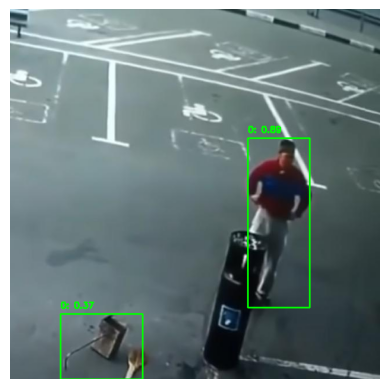

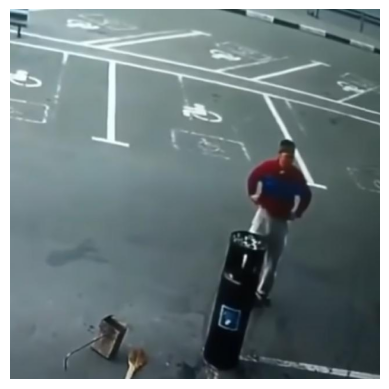

In [34]:
# 生成检测框图像
image_with_boxes = draw_boxes(image, outputs, [0])

# 显示图像
plt.imshow(cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

image_with_boxes = draw_boxes(image, outputs_adv, [0])

plt.imshow(cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

In [35]:
image_path = '/content/drive/My Drive/2024 Fall/COMS 6730/Projects/Person-Detection-YOLOV8N-Dectection/test/images/553_png.rf.53156c7f677314703d70b307e360efb6.jpg'
image = cv2.imread(image_path)

outputs = model(image)

# 将图像和标签转换为 Tensor
images = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0).to(device) / 255.0
labels = torch.tensor([0]).to(device)

# 生成对抗样本
print("Generating adversarial examples...")
images_adv = pgd_attack(model, images, epsilon, alpha, num_iter)

# 使用对抗样本进行预测
outputs_adv = model(images_adv)


0: 640x640 1 Person, 9.7ms
Speed: 3.9ms preprocess, 9.7ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Person, 8.7ms
Speed: 0.0ms preprocess, 8.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Person, 10.1ms
Speed: 0.2ms preprocess, 10.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Person, 10.4ms
Speed: 0.1ms preprocess, 10.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Person, 9.5ms
Speed: 0.1ms preprocess, 9.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Person, 10.0ms
Speed: 0.2ms preprocess, 10.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Person, 12.2ms
Speed: 0.0ms preprocess, 12.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Person, 9.4ms
Speed: 0.0ms preprocess, 9.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Generating adversarial examples...
tensor(1.1922, device='cuda:0', grad_fn=<SubBackward0>)
tensor(1.2230, device='cuda:0', grad_fn=<SubBackward0>)
tensor(1.2230, device='cuda:0', grad_fn=<SubBackward0>)
tensor(1.2230, device='cuda:0', grad_fn=<SubBackward0>)
tensor(1.2230, device='cuda:0', grad_fn=<SubBackward0>)
tensor(1.2230, device='cuda:0', grad_fn=<SubBackward0>)
tensor(1.2230, device='cuda:0', grad_fn=<SubBackward0>)
tensor(1.2230, device='cuda:0', grad_fn=<SubBackward0>)
tensor(1.2230, device='cuda:0', grad_fn=<SubBackward0>)


0: 640x640 1 Person, 12.4ms
Speed: 0.0ms preprocess, 12.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Person, 8.5ms
Speed: 0.0ms preprocess, 8.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Person, 12.7ms
Speed: 0.2ms preprocess, 12.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Person, 9.5ms
Speed: 0.0ms preprocess, 9.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Person, 9.7ms
Speed: 0.0ms preprocess, 9.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Person, 9.4ms
Speed: 0.0ms preprocess, 9.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Person, 8.4ms
Speed: 0.0ms preprocess, 8.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Person, 8.4ms
Speed: 0.1ms preprocess, 8.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 6

tensor(1.2230, device='cuda:0', grad_fn=<SubBackward0>)
tensor(1.2230, device='cuda:0', grad_fn=<SubBackward0>)
tensor(1.2230, device='cuda:0', grad_fn=<SubBackward0>)
tensor(1.2230, device='cuda:0', grad_fn=<SubBackward0>)
tensor(1.2230, device='cuda:0', grad_fn=<SubBackward0>)
tensor(1.2230, device='cuda:0', grad_fn=<SubBackward0>)
tensor(1.2230, device='cuda:0', grad_fn=<SubBackward0>)
tensor(1.2230, device='cuda:0', grad_fn=<SubBackward0>)
tensor(1.2230, device='cuda:0', grad_fn=<SubBackward0>)
tensor(1.2230, device='cuda:0', grad_fn=<SubBackward0>)


0: 640x640 1 Person, 10.5ms
Speed: 0.0ms preprocess, 10.5ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Person, 10.2ms
Speed: 0.1ms preprocess, 10.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Person, 10.5ms
Speed: 0.0ms preprocess, 10.5ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Person, 10.3ms
Speed: 0.0ms preprocess, 10.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Person, 9.9ms
Speed: 0.1ms preprocess, 9.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Person, 10.5ms
Speed: 0.0ms preprocess, 10.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Person, 11.0ms
Speed: 0.0ms preprocess, 11.0ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Person, 9.7ms
Speed: 0.0ms preprocess, 9.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 64

tensor(1.2230, device='cuda:0', grad_fn=<SubBackward0>)
tensor(1.2230, device='cuda:0', grad_fn=<SubBackward0>)
tensor(1.2230, device='cuda:0', grad_fn=<SubBackward0>)
tensor(1.2230, device='cuda:0', grad_fn=<SubBackward0>)
tensor(1.2230, device='cuda:0', grad_fn=<SubBackward0>)
tensor(1.2230, device='cuda:0', grad_fn=<SubBackward0>)
tensor(1.2230, device='cuda:0', grad_fn=<SubBackward0>)
tensor(1.2230, device='cuda:0', grad_fn=<SubBackward0>)
tensor(1.2230, device='cuda:0', grad_fn=<SubBackward0>)
tensor(1.2230, device='cuda:0', grad_fn=<SubBackward0>)


0: 640x640 1 Person, 16.6ms
Speed: 0.0ms preprocess, 16.6ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Person, 14.7ms
Speed: 0.1ms preprocess, 14.7ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Person, 18.4ms
Speed: 0.0ms preprocess, 18.4ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Person, 14.5ms
Speed: 0.0ms preprocess, 14.5ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Person, 11.8ms
Speed: 0.1ms preprocess, 11.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Person, 18.2ms
Speed: 0.1ms preprocess, 18.2ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Person, 13.3ms
Speed: 0.0ms preprocess, 13.3ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Person, 14.1ms
Speed: 0.0ms preprocess, 14.1ms inference, 3.1ms postprocess per image at shape (1, 3, 640

tensor(1.2230, device='cuda:0', grad_fn=<SubBackward0>)
tensor(1.2230, device='cuda:0', grad_fn=<SubBackward0>)
tensor(1.2230, device='cuda:0', grad_fn=<SubBackward0>)
tensor(1.2230, device='cuda:0', grad_fn=<SubBackward0>)
tensor(1.2230, device='cuda:0', grad_fn=<SubBackward0>)
tensor(1.2230, device='cuda:0', grad_fn=<SubBackward0>)
tensor(1.2230, device='cuda:0', grad_fn=<SubBackward0>)



0: 640x640 1 Person, 12.3ms
Speed: 0.0ms preprocess, 12.3ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Person, 12.3ms
Speed: 0.1ms preprocess, 12.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Person, 12.9ms
Speed: 0.0ms preprocess, 12.9ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Person, 12.7ms
Speed: 0.0ms preprocess, 12.7ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Person, 12.6ms
Speed: 0.0ms preprocess, 12.6ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Person, 12.3ms
Speed: 0.0ms preprocess, 12.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Person, 12.4ms
Speed: 0.1ms preprocess, 12.4ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Person, 12.9ms
Speed: 0.0ms preprocess, 12.9ms inference, 2.5ms postprocess per image at shape (1, 3, 64

tensor(1.2230, device='cuda:0', grad_fn=<SubBackward0>)
tensor(1.2230, device='cuda:0', grad_fn=<SubBackward0>)
tensor(1.2230, device='cuda:0', grad_fn=<SubBackward0>)
tensor(1.2230, device='cuda:0', grad_fn=<SubBackward0>)
tensor(1.2230, device='cuda:0', grad_fn=<SubBackward0>)
tensor(1.2230, device='cuda:0', grad_fn=<SubBackward0>)
tensor(1.2230, device='cuda:0', grad_fn=<SubBackward0>)
tensor(1.2230, device='cuda:0', grad_fn=<SubBackward0>)



0: 640x640 1 Person, 18.8ms
Speed: 0.0ms preprocess, 18.8ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Person, 14.7ms
Speed: 0.0ms preprocess, 14.7ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Person, 12.7ms
Speed: 0.0ms preprocess, 12.7ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Person, 13.0ms
Speed: 0.1ms preprocess, 13.0ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Person, 14.8ms
Speed: 0.1ms preprocess, 14.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Person, 14.2ms
Speed: 0.0ms preprocess, 14.2ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Person, 12.6ms
Speed: 0.0ms preprocess, 12.6ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)



tensor(1.2230, device='cuda:0', grad_fn=<SubBackward0>)
tensor(1.2230, device='cuda:0', grad_fn=<SubBackward0>)
tensor(1.2230, device='cuda:0', grad_fn=<SubBackward0>)
tensor(1.2230, device='cuda:0', grad_fn=<SubBackward0>)
tensor(1.2230, device='cuda:0', grad_fn=<SubBackward0>)
tensor(1.2230, device='cuda:0', grad_fn=<SubBackward0>)
tensor(1.2230, device='cuda:0', grad_fn=<SubBackward0>)
tensor(1.2230, device='cuda:0', grad_fn=<SubBackward0>)


0: 640x640 1 Person, 16.8ms
Speed: 0.0ms preprocess, 16.8ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Person, 12.9ms
Speed: 0.1ms preprocess, 12.9ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Person, 13.5ms
Speed: 0.0ms preprocess, 13.5ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Person, 12.8ms
Speed: 0.0ms preprocess, 12.8ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Person, 13.1ms
Speed: 0.1ms preprocess, 13.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Person, 13.6ms
Speed: 0.0ms preprocess, 13.6ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Person, 14.6ms
Speed: 0.0ms preprocess, 14.6ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Person, 12.6ms
Speed: 0.0ms preprocess, 12.6ms inference, 3.1ms postprocess per image at shape (1, 3, 640

tensor(1.2230, device='cuda:0', grad_fn=<SubBackward0>)
tensor(1.2230, device='cuda:0', grad_fn=<SubBackward0>)
tensor(1.2230, device='cuda:0', grad_fn=<SubBackward0>)
tensor(1.2230, device='cuda:0', grad_fn=<SubBackward0>)
tensor(1.2230, device='cuda:0', grad_fn=<SubBackward0>)
tensor(1.2230, device='cuda:0', grad_fn=<SubBackward0>)
tensor(1.2230, device='cuda:0', grad_fn=<SubBackward0>)
tensor(1.2230, device='cuda:0', grad_fn=<SubBackward0>)


0: 640x640 1 Person, 14.2ms
Speed: 0.0ms preprocess, 14.2ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Person, 12.1ms
Speed: 0.0ms preprocess, 12.1ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Person, 14.0ms
Speed: 0.0ms preprocess, 14.0ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Person, 12.5ms
Speed: 0.0ms preprocess, 12.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Person, 12.8ms
Speed: 0.0ms preprocess, 12.8ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Person, 14.0ms
Speed: 0.1ms preprocess, 14.0ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Person, 11.8ms
Speed: 0.0ms preprocess, 11.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Person, 15.4ms
Speed: 0.0ms preprocess, 15.4ms inference, 2.6ms postprocess per image at shape (1, 3, 640

tensor(1.2230, device='cuda:0', grad_fn=<SubBackward0>)
tensor(1.2230, device='cuda:0', grad_fn=<SubBackward0>)
tensor(1.2230, device='cuda:0', grad_fn=<SubBackward0>)
tensor(1.2230, device='cuda:0', grad_fn=<SubBackward0>)
tensor(1.2230, device='cuda:0', grad_fn=<SubBackward0>)
tensor(1.2230, device='cuda:0', grad_fn=<SubBackward0>)
tensor(1.2230, device='cuda:0', grad_fn=<SubBackward0>)
tensor(1.2230, device='cuda:0', grad_fn=<SubBackward0>)


0: 640x640 1 Person, 17.7ms
Speed: 0.0ms preprocess, 17.7ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Person, 13.6ms
Speed: 0.0ms preprocess, 13.6ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Person, 12.6ms
Speed: 0.0ms preprocess, 12.6ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Person, 21.1ms
Speed: 0.0ms preprocess, 21.1ms inference, 4.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Person, 15.3ms
Speed: 0.1ms preprocess, 15.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Person, 13.0ms
Speed: 0.0ms preprocess, 13.0ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Person, 14.4ms
Speed: 0.0ms preprocess, 14.4ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Person, 13.6ms


tensor(1.2230, device='cuda:0', grad_fn=<SubBackward0>)
tensor(1.2230, device='cuda:0', grad_fn=<SubBackward0>)
tensor(1.2230, device='cuda:0', grad_fn=<SubBackward0>)
tensor(1.2230, device='cuda:0', grad_fn=<SubBackward0>)
tensor(1.2230, device='cuda:0', grad_fn=<SubBackward0>)
tensor(1.2230, device='cuda:0', grad_fn=<SubBackward0>)
tensor(1.2230, device='cuda:0', grad_fn=<SubBackward0>)


Speed: 0.1ms preprocess, 13.6ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Person, 15.1ms
Speed: 0.0ms preprocess, 15.1ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Person, 13.2ms
Speed: 0.0ms preprocess, 13.2ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Person, 10.1ms
Speed: 0.0ms preprocess, 10.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Person, 12.2ms
Speed: 0.0ms preprocess, 12.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Person, 9.3ms
Speed: 0.0ms preprocess, 9.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Person, 9.5ms
Speed: 0.1ms preprocess, 9.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Person, 10.4ms
Speed: 0.1ms preprocess, 10.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Person, 11.

tensor(1.2230, device='cuda:0', grad_fn=<SubBackward0>)
tensor(1.2230, device='cuda:0', grad_fn=<SubBackward0>)
tensor(1.2230, device='cuda:0', grad_fn=<SubBackward0>)
tensor(1.2230, device='cuda:0', grad_fn=<SubBackward0>)
tensor(1.2230, device='cuda:0', grad_fn=<SubBackward0>)
tensor(1.2230, device='cuda:0', grad_fn=<SubBackward0>)
tensor(1.2230, device='cuda:0', grad_fn=<SubBackward0>)
tensor(1.2230, device='cuda:0', grad_fn=<SubBackward0>)
tensor(1.2230, device='cuda:0', grad_fn=<SubBackward0>)


0: 640x640 1 Person, 11.1ms
Speed: 0.0ms preprocess, 11.1ms inference, 4.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Person, 20.6ms
Speed: 0.1ms preprocess, 20.6ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Person, 10.5ms
Speed: 0.0ms preprocess, 10.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Person, 12.5ms
Speed: 0.0ms preprocess, 12.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Person, 10.2ms
Speed: 0.0ms preprocess, 10.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Person, 11.0ms
Speed: 0.0ms preprocess, 11.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Person, 11.9ms
Speed: 0.0ms preprocess, 11.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Person, 12.3ms
Speed: 0.0ms preprocess, 12.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640

tensor(1.2230, device='cuda:0', grad_fn=<SubBackward0>)
tensor(1.2230, device='cuda:0', grad_fn=<SubBackward0>)
tensor(1.2230, device='cuda:0', grad_fn=<SubBackward0>)
tensor(1.2230, device='cuda:0', grad_fn=<SubBackward0>)
tensor(1.2230, device='cuda:0', grad_fn=<SubBackward0>)
tensor(1.2230, device='cuda:0', grad_fn=<SubBackward0>)
tensor(1.2230, device='cuda:0', grad_fn=<SubBackward0>)
tensor(1.2230, device='cuda:0', grad_fn=<SubBackward0>)
tensor(1.2230, device='cuda:0', grad_fn=<SubBackward0>)


0: 640x640 1 Person, 11.6ms
Speed: 0.0ms preprocess, 11.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Person, 9.7ms
Speed: 0.0ms preprocess, 9.7ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Person, 10.1ms
Speed: 0.0ms preprocess, 10.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Person, 9.7ms
Speed: 0.0ms preprocess, 9.7ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Person, 10.6ms
Speed: 0.1ms preprocess, 10.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Person, 12.6ms
Speed: 0.0ms preprocess, 12.6ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Person, 10.4ms
Speed: 0.0ms preprocess, 10.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Person, 11.5ms
Speed: 0.1ms preprocess, 11.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 64

tensor(1.2230, device='cuda:0', grad_fn=<SubBackward0>)
tensor(1.2230, device='cuda:0', grad_fn=<SubBackward0>)
tensor(1.2230, device='cuda:0', grad_fn=<SubBackward0>)
tensor(1.2230, device='cuda:0', grad_fn=<SubBackward0>)
tensor(1.2230, device='cuda:0', grad_fn=<SubBackward0>)
tensor(1.2230, device='cuda:0', grad_fn=<SubBackward0>)
tensor(1.2230, device='cuda:0', grad_fn=<SubBackward0>)


0.87


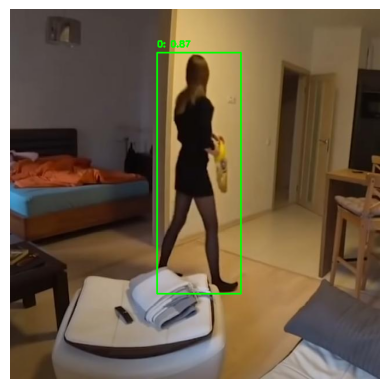

0.86


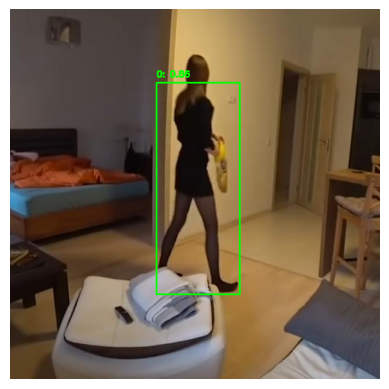

In [37]:
# 生成检测框图像
image_with_boxes = draw_boxes(image, outputs, [0])

# 显示图像
plt.imshow(cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

image_with_boxes = draw_boxes(image, outputs_adv, [0])

plt.imshow(cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

In [38]:
image_path = '/content/drive/My Drive/2024 Fall/COMS 6730/Projects/Person-Detection-YOLOV8N-Dectection/test/images/556_png.rf.04e60f97d172739af5012df81fcf73ab.jpg'
image = cv2.imread(image_path)

outputs = model(image)

# 将图像和标签转换为 Tensor
images = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0).to(device) / 255.0
labels = torch.tensor([0]).to(device)

# 生成对抗样本
print("Generating adversarial examples...")
images_adv = pgd_attack(model, images, epsilon, alpha, num_iter)

# 使用对抗样本进行预测
outputs_adv = model(images_adv)


0: 640x640 1 Person, 10.7ms
Speed: 2.3ms preprocess, 10.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 Persons, 8.4ms
Speed: 0.0ms preprocess, 8.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

WARNING ⚠️ torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1.0299999713897705. Dividing input by 255.
0: 640x640 (no detections), 14.0ms
Speed: 0.0ms preprocess, 14.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

WARNING ⚠️ torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1.0299999713897705. Dividing input by 255.
0: 640x640 (no detections), 9.4ms
Speed: 0.0ms preprocess, 9.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

WARNING ⚠️ torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1.0299999713897705. Dividing input by 255.
0: 640x640 (no detections), 9.5ms
Speed: 0.0ms preprocess, 9.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640,

Generating adversarial examples...
tensor(1.1841, device='cuda:0', grad_fn=<SubBackward0>)


WARNING ⚠️ torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1.0299999713897705. Dividing input by 255.
0: 640x640 (no detections), 10.2ms
Speed: 0.0ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

WARNING ⚠️ torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1.0299999713897705. Dividing input by 255.
0: 640x640 (no detections), 9.5ms
Speed: 0.0ms preprocess, 9.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

WARNING ⚠️ torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1.0299999713897705. Dividing input by 255.
0: 640x640 (no detections), 11.0ms
Speed: 0.0ms preprocess, 11.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

WARNING ⚠️ torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1.0299999713897705. Dividing input by 255.
0: 640x640 (no detections), 17.2ms
Speed: 0.0ms preprocess, 17.2ms inference, 2.1ms postprocess per image at shape (1, 3, 6

0.82


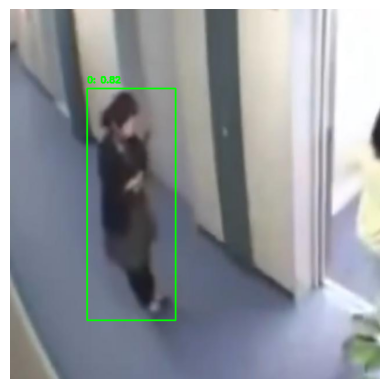

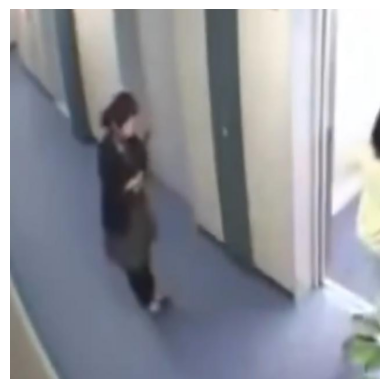

In [39]:
# 生成检测框图像
image_with_boxes = draw_boxes(image, outputs, [0])

# 显示图像
plt.imshow(cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

image_with_boxes = draw_boxes(image, outputs_adv, [0])

plt.imshow(cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

In [40]:
image_path = '/content/drive/My Drive/2024 Fall/COMS 6730/Projects/Person-Detection-YOLOV8N-Dectection/test/images/554_png.rf.537775b63b27818ceb81d8a71aa48abf.jpg'
image = cv2.imread(image_path)

outputs = model(image)

# 将图像和标签转换为 Tensor
images = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0).to(device) / 255.0
labels = torch.tensor([0]).to(device)

# 生成对抗样本
print("Generating adversarial examples...")
images_adv = pgd_attack(model, images, epsilon, alpha, num_iter)

# 使用对抗样本进行预测
outputs_adv = model(images_adv)


0: 640x640 1 Person, 9.1ms
Speed: 2.4ms preprocess, 9.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Person, 13.0ms
Speed: 0.0ms preprocess, 13.0ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

WARNING ⚠️ torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1.0299999713897705. Dividing input by 255.
0: 640x640 (no detections), 14.0ms
Speed: 0.0ms preprocess, 14.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

WARNING ⚠️ torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1.0299999713897705. Dividing input by 255.
0: 640x640 (no detections), 12.7ms
Speed: 0.0ms preprocess, 12.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

WARNING ⚠️ torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1.0299999713897705. Dividing input by 255.
0: 640x640 (no detections), 13.0ms
Speed: 0.0ms preprocess, 13.0ms inference, 1.8ms postprocess per image at shape (1, 3, 6

Generating adversarial examples...
tensor(1.1927, device='cuda:0', grad_fn=<SubBackward0>)


0: 640x640 (no detections), 12.1ms
Speed: 0.0ms preprocess, 12.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

WARNING ⚠️ torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1.0299999713897705. Dividing input by 255.
0: 640x640 (no detections), 9.9ms
Speed: 0.0ms preprocess, 9.9ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

WARNING ⚠️ torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1.0299999713897705. Dividing input by 255.
0: 640x640 (no detections), 9.4ms
Speed: 0.0ms preprocess, 9.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

WARNING ⚠️ torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1.0299999713897705. Dividing input by 255.
0: 640x640 (no detections), 10.5ms
Speed: 0.0ms preprocess, 10.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

WARNING ⚠️ torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1.0299999713897705. Dividing input 

0.89


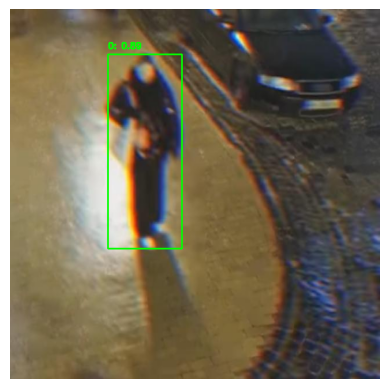

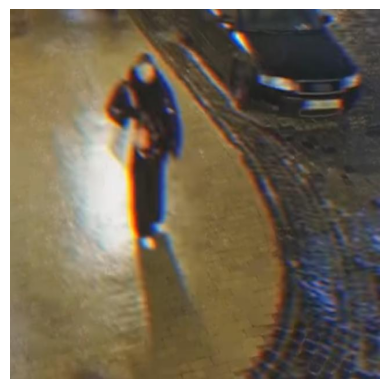

In [41]:
# 生成检测框图像
image_with_boxes = draw_boxes(image, outputs, [0])

# 显示图像
plt.imshow(cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

image_with_boxes = draw_boxes(image, outputs_adv, [0])

plt.imshow(cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

In [42]:
image_path = '/content/drive/My Drive/2024 Fall/COMS 6730/Projects/Person-Detection-YOLOV8N-Dectection/test/images/557_png.rf.8f5abb75a4102fc16dbaf19279e33389.jpg'
image = cv2.imread(image_path)

outputs = model(image)

# 将图像和标签转换为 Tensor
images = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0).to(device) / 255.0
labels = torch.tensor([0]).to(device)

# 生成对抗样本
print("Generating adversarial examples...")
images_adv = pgd_attack(model, images, epsilon, alpha, num_iter)

# 使用对抗样本进行预测
outputs_adv = model(images_adv)


0: 640x640 3 Persons, 10.5ms
Speed: 3.5ms preprocess, 10.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 Persons, 8.2ms
Speed: 0.0ms preprocess, 8.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING ⚠️ torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1.0299999713897705. Dividing input by 255.
0: 640x640 (no detections), 10.2ms
Speed: 0.0ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

WARNING ⚠️ torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1.0299999713897705. Dividing input by 255.
0: 640x640 (no detections), 10.3ms
Speed: 0.0ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

WARNING ⚠️ torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1.0299999713897705. Dividing input by 255.
0: 640x640 (no detections), 10.6ms
Speed: 0.0ms preprocess, 10.6ms inference, 1.3ms postprocess per image at shape (1, 3,

Generating adversarial examples...
tensor(1.2399, device='cuda:0', grad_fn=<SubBackward0>)



WARNING ⚠️ torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1.0299999713897705. Dividing input by 255.
0: 640x640 (no detections), 10.4ms
Speed: 0.0ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

WARNING ⚠️ torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1.0299999713897705. Dividing input by 255.
0: 640x640 (no detections), 11.8ms
Speed: 0.0ms preprocess, 11.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

WARNING ⚠️ torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1.0299999713897705. Dividing input by 255.
0: 640x640 (no detections), 10.4ms
Speed: 0.0ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

WARNING ⚠️ torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1.0299999713897705. Dividing input by 255.
0: 640x640 (no detections), 11.6ms
Speed: 0.0ms preprocess, 11.6ms inference, 1.7ms postprocess per image at shape (1, 3

0.90
0.79
0.48


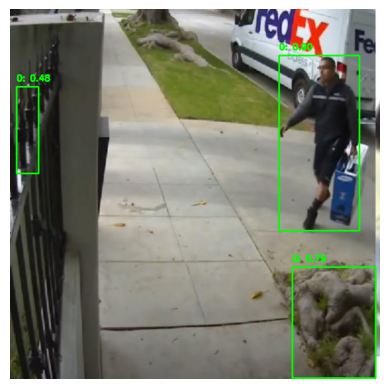

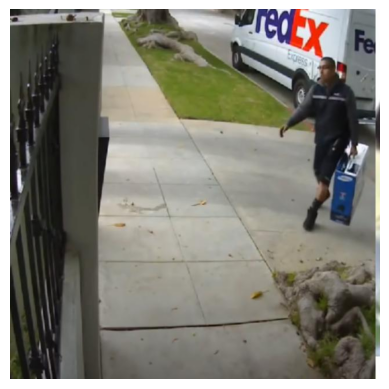

In [43]:
# 生成检测框图像
image_with_boxes = draw_boxes(image, outputs, [0])

# 显示图像
plt.imshow(cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

image_with_boxes = draw_boxes(image, outputs_adv, [0])

plt.imshow(cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

In [44]:
image_path = '/content/drive/My Drive/2024 Fall/COMS 6730/Projects/Person-Detection-YOLOV8N-Dectection/test/images/555_png.rf.446202f35c08bcb3670180cf46677a2a.jpg'
image = cv2.imread(image_path)

outputs = model(image)

# 将图像和标签转换为 Tensor
images = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0).to(device) / 255.0
labels = torch.tensor([0]).to(device)

# 生成对抗样本
print("Generating adversarial examples...")
images_adv = pgd_attack(model, images, epsilon, alpha, num_iter)

# 使用对抗样本进行预测
outputs_adv = model(images_adv)


0: 640x640 3 Persons, 7.8ms
Speed: 2.3ms preprocess, 7.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 Persons, 10.8ms
Speed: 0.0ms preprocess, 10.8ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

WARNING ⚠️ torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1.0299999713897705. Dividing input by 255.
0: 640x640 (no detections), 18.0ms
Speed: 0.1ms preprocess, 18.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

WARNING ⚠️ torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1.0299999713897705. Dividing input by 255.
0: 640x640 (no detections), 9.4ms
Speed: 0.0ms preprocess, 9.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

WARNING ⚠️ torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1.0299999713897705. Dividing input by 255.
0: 640x640 (no detections), 11.5ms
Speed: 0.0ms preprocess, 11.5ms inference, 1.3ms postprocess per image at shape (1, 3, 6

Generating adversarial examples...
tensor(1.0674, device='cuda:0', grad_fn=<SubBackward0>)


0: 640x640 (no detections), 11.8ms
Speed: 0.0ms preprocess, 11.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

WARNING ⚠️ torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1.0299999713897705. Dividing input by 255.
0: 640x640 (no detections), 9.3ms
Speed: 0.0ms preprocess, 9.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

WARNING ⚠️ torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1.0299999713897705. Dividing input by 255.
0: 640x640 (no detections), 10.8ms
Speed: 0.0ms preprocess, 10.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

WARNING ⚠️ torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1.0299999713897705. Dividing input by 255.
0: 640x640 (no detections), 11.0ms
Speed: 0.0ms preprocess, 11.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

WARNING ⚠️ torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1.0299999713897705. Dividing inpu

0.77
0.46
0.29


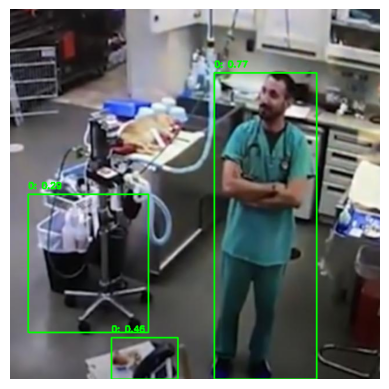

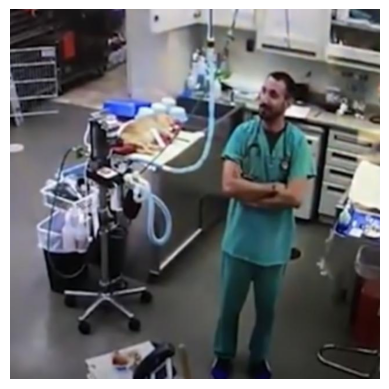

In [45]:
# 生成检测框图像
image_with_boxes = draw_boxes(image, outputs, [0])

# 显示图像
plt.imshow(cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

image_with_boxes = draw_boxes(image, outputs_adv, [0])

plt.imshow(cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

In [46]:
image_path = '/content/drive/My Drive/2024 Fall/COMS 6730/Projects/Person-Detection-YOLOV8N-Dectection/test/images/551_png.rf.a6f93649aaef547a01818b1a84c4daea.jpg'
image = cv2.imread(image_path)

outputs = model(image)

# 将图像和标签转换为 Tensor
images = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0).to(device) / 255.0
labels = torch.tensor([0]).to(device)

# 生成对抗样本
print("Generating adversarial examples...")
images_adv = pgd_attack(model, images, epsilon, alpha, num_iter)

# 使用对抗样本进行预测
outputs_adv = model(images_adv)


0: 640x640 1 Person, 9.8ms
Speed: 2.7ms preprocess, 9.8ms inference, 3.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 19.2ms
Speed: 0.0ms preprocess, 19.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 11.0ms
Speed: 0.0ms preprocess, 11.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 8.6ms
Speed: 0.3ms preprocess, 8.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 8.6ms
Speed: 0.0ms preprocess, 8.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.2ms
Speed: 0.1ms preprocess, 9.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.4ms
Speed: 0.1ms preprocess, 9.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.5ms
Speed: 0.1ms preprocess, 9.5ms inference, 1.6ms pos

Generating adversarial examples...


0: 640x640 (no detections), 14.2ms
Speed: 0.0ms preprocess, 14.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.5ms
Speed: 0.0ms preprocess, 9.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.1ms
Speed: 0.0ms preprocess, 9.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.5ms
Speed: 0.0ms preprocess, 12.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.6ms
Speed: 0.0ms preprocess, 9.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.7ms
Speed: 0.0ms preprocess, 9.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 11.3ms
Speed: 0.0ms preprocess, 11.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 15.6ms
Speed: 0.0ms preprocess, 15.6ms inference,

0.79


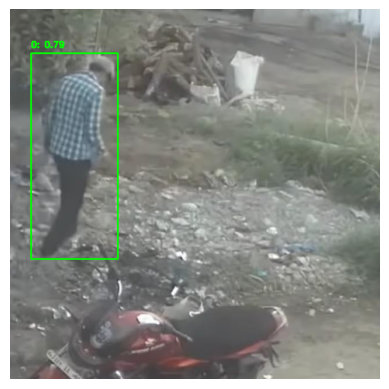

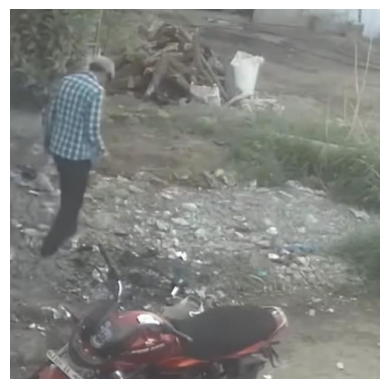

In [47]:
# 生成检测框图像
image_with_boxes = draw_boxes(image, outputs, [0])

# 显示图像
plt.imshow(cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

image_with_boxes = draw_boxes(image, outputs_adv, [0])

plt.imshow(cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

In [48]:
image_path = '/content/drive/My Drive/2024 Fall/COMS 6730/Projects/Person-Detection-YOLOV8N-Dectection/test/images/545_png.rf.49ce1de985fff5c22ca5f340decdffdb.jpg'
image = cv2.imread(image_path)

outputs = model(image)

# 将图像和标签转换为 Tensor
images = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0).to(device) / 255.0
labels = torch.tensor([0]).to(device)

# 生成对抗样本
print("Generating adversarial examples...")
images_adv = pgd_attack(model, images, epsilon, alpha, num_iter)

# 使用对抗样本进行预测
outputs_adv = model(images_adv)


0: 640x640 1 Person, 33.7ms
Speed: 4.5ms preprocess, 33.7ms inference, 3.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Person, 21.4ms
Speed: 0.0ms preprocess, 21.4ms inference, 3.8ms postprocess per image at shape (1, 3, 640, 640)

WARNING ⚠️ torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1.0299999713897705. Dividing input by 255.
0: 640x640 (no detections), 30.9ms
Speed: 0.0ms preprocess, 30.9ms inference, 6.2ms postprocess per image at shape (1, 3, 640, 640)

WARNING ⚠️ torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1.0299999713897705. Dividing input by 255.
0: 640x640 (no detections), 27.1ms
Speed: 0.0ms preprocess, 27.1ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

WARNING ⚠️ torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1.0299999713897705. Dividing input by 255.
0: 640x640 (no detections), 26.3ms
Speed: 0.0ms preprocess, 26.3ms inference, 4.0ms postprocess per image at shape (1, 3,

Generating adversarial examples...
tensor(1.3881, device='cuda:0', grad_fn=<SubBackward0>)


WARNING ⚠️ torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1.0299999713897705. Dividing input by 255.
0: 640x640 (no detections), 42.4ms
Speed: 0.0ms preprocess, 42.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

WARNING ⚠️ torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1.0299999713897705. Dividing input by 255.
0: 640x640 (no detections), 28.4ms
Speed: 0.0ms preprocess, 28.4ms inference, 6.5ms postprocess per image at shape (1, 3, 640, 640)

WARNING ⚠️ torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1.0299999713897705. Dividing input by 255.
0: 640x640 (no detections), 26.8ms
Speed: 0.0ms preprocess, 26.8ms inference, 7.5ms postprocess per image at shape (1, 3, 640, 640)

WARNING ⚠️ torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1.0299999713897705. Dividing input by 255.
0: 640x640 (no detections), 28.9ms
Speed: 0.0ms preprocess, 28.9ms inference, 1.7ms postprocess per image at shape (1, 3,

0.85


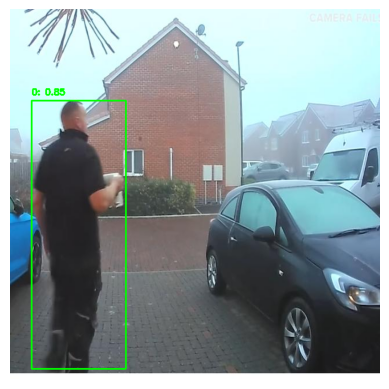

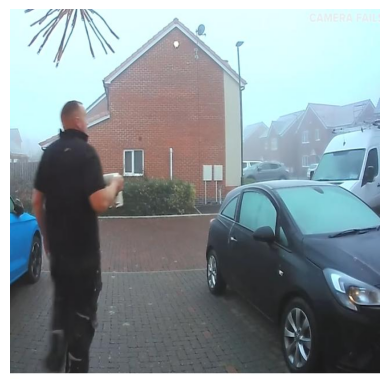

In [49]:
# 生成检测框图像
image_with_boxes = draw_boxes(image, outputs, [0])

# 显示图像
plt.imshow(cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

image_with_boxes = draw_boxes(image, outputs_adv, [0])

plt.imshow(cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

In [50]:
image_path = '/content/drive/My Drive/2024 Fall/COMS 6730/Projects/Person-Detection-YOLOV8N-Dectection/test/images/51_png.rf.127d6881ff6b79a0eccaa4998ac8f34b.jpg'
image = cv2.imread(image_path)

outputs = model(image)

# 将图像和标签转换为 Tensor
images = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0).to(device) / 255.0
labels = torch.tensor([0]).to(device)

# 生成对抗样本
print("Generating adversarial examples...")
images_adv = pgd_attack(model, images, epsilon, alpha, num_iter)

# 使用对抗样本进行预测
outputs_adv = model(images_adv)


0: 640x640 3 Persons, 11.0ms
Speed: 2.1ms preprocess, 11.0ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 Persons, 10.5ms
Speed: 0.0ms preprocess, 10.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

WARNING ⚠️ torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1.0299999713897705. Dividing input by 255.
0: 640x640 (no detections), 17.6ms
Speed: 0.0ms preprocess, 17.6ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

WARNING ⚠️ torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1.0299999713897705. Dividing input by 255.
0: 640x640 (no detections), 10.8ms
Speed: 0.0ms preprocess, 10.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

WARNING ⚠️ torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1.0299999713897705. Dividing input by 255.
0: 640x640 (no detections), 10.2ms
Speed: 0.0ms preprocess, 10.2ms inference, 1.5ms postprocess per image at shape (1, 

Generating adversarial examples...
tensor(1.3166, device='cuda:0', grad_fn=<SubBackward0>)


0: 640x640 (no detections), 11.1ms
Speed: 0.0ms preprocess, 11.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

WARNING ⚠️ torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1.0299999713897705. Dividing input by 255.
0: 640x640 (no detections), 10.4ms
Speed: 0.0ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

WARNING ⚠️ torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1.0299999713897705. Dividing input by 255.
0: 640x640 (no detections), 11.6ms
Speed: 0.0ms preprocess, 11.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

WARNING ⚠️ torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1.0299999713897705. Dividing input by 255.
0: 640x640 (no detections), 11.0ms
Speed: 0.0ms preprocess, 11.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

WARNING ⚠️ torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1.0299999713897705. Dividing in

0.88
0.87
0.80


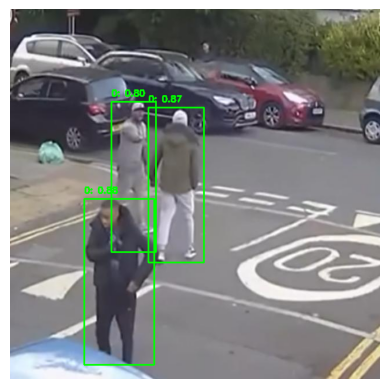

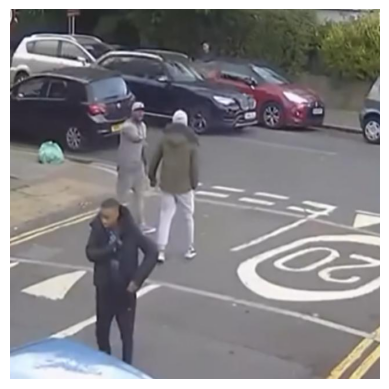

In [51]:
# 生成检测框图像
image_with_boxes = draw_boxes(image, outputs, [0])

# 显示图像
plt.imshow(cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

image_with_boxes = draw_boxes(image, outputs_adv, [0])

plt.imshow(cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

In [52]:
image_path = '/content/drive/My Drive/2024 Fall/COMS 6730/Projects/Person-Detection-YOLOV8N-Dectection/test/images/53_png.rf.b6aaa97737f85d6fa41b00637ab72fd9.jpg'
image = cv2.imread(image_path)

outputs = model(image)

# 将图像和标签转换为 Tensor
images = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0).to(device) / 255.0
labels = torch.tensor([0]).to(device)

# 生成对抗样本
print("Generating adversarial examples...")
images_adv = pgd_attack(model, images, epsilon, alpha, num_iter)

# 使用对抗样本进行预测
outputs_adv = model(images_adv)


0: 640x640 2 Persons, 21.9ms
Speed: 3.1ms preprocess, 21.9ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 Persons, 10.2ms
Speed: 0.0ms preprocess, 10.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

WARNING ⚠️ torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1.0299999713897705. Dividing input by 255.
0: 640x640 (no detections), 9.6ms
Speed: 0.0ms preprocess, 9.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

WARNING ⚠️ torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1.0299999713897705. Dividing input by 255.
0: 640x640 (no detections), 10.4ms
Speed: 0.0ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

WARNING ⚠️ torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1.0299999713897705. Dividing input by 255.
0: 640x640 (no detections), 11.1ms
Speed: 0.0ms preprocess, 11.1ms inference, 1.3ms postprocess per image at shape (1, 3,

Generating adversarial examples...
tensor(0.8746, device='cuda:0', grad_fn=<SubBackward0>)


0: 640x640 (no detections), 11.0ms
Speed: 0.0ms preprocess, 11.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

WARNING ⚠️ torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1.0299999713897705. Dividing input by 255.
0: 640x640 (no detections), 10.4ms
Speed: 0.0ms preprocess, 10.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

WARNING ⚠️ torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1.0299999713897705. Dividing input by 255.
0: 640x640 (no detections), 9.6ms
Speed: 0.0ms preprocess, 9.6ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

WARNING ⚠️ torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1.0299999713897705. Dividing input by 255.
0: 640x640 (no detections), 8.6ms
Speed: 0.1ms preprocess, 8.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

WARNING ⚠️ torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1.0299999713897705. Dividing input 

0.88
0.32


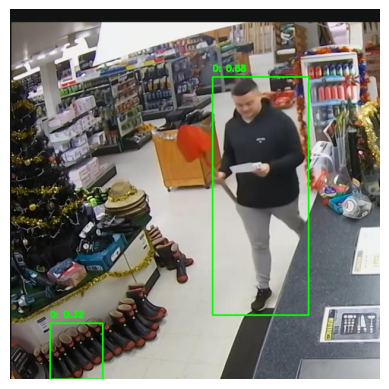

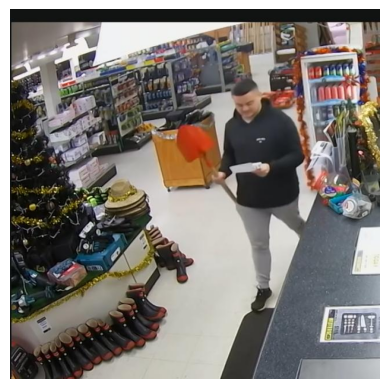

In [53]:
# 生成检测框图像
image_with_boxes = draw_boxes(image, outputs, [0])

# 显示图像
plt.imshow(cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

image_with_boxes = draw_boxes(image, outputs_adv, [0])

plt.imshow(cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()